The following are three different implementations of Linear Regression to demonstrate basic principles such as Gradient Descent, mini-batching in both numpy and Tensorflow.

Much credit goes to Sebastian Raschka, Aymeric Damien and Michelle Fullwood for their code, blogposts and presentations:

- Sebastian Raschka "Single-Layer Neural Networks and Gradient Descent" https://sebastianraschka.com/Articles/2015_singlelayer_neurons.html#gradient-descent
- Aymeric Damien Linear Regression in Tensorflow example: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/2_BasicModels/linear_regression.ipynb
- Michelle Fullwood "A gentle introduction to deep learning with TensorFlow" at PyCon 2017
https://www.youtube.com/watch?v=5e0TbyCkbCY&list=WL&index=5
https://github.com/michelleful/PyCon2017/blob/master/notebooks/Sample%20TensorFlow%20code.ipynb


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

%matplotlib inline
tf.__version__

'1.1.0'

### Get Housing Data

In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


We only take the number of rooms as our feature and the median value as our target

In [5]:
X = df[['RM']].values
y = df['MEDV'].values

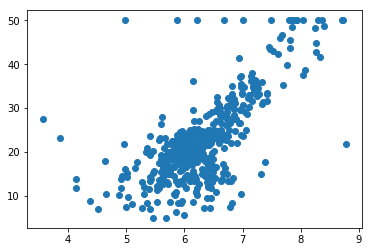

In [6]:
plt.scatter(X, y)

We scale the feature and target which helps with convergence etc.

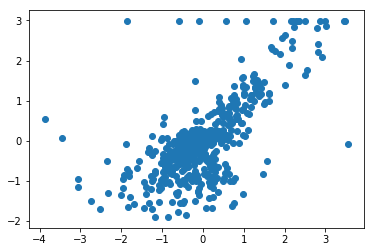

In [8]:

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
plt.scatter(X_std, y_std)

### Numpy version

#### Linear, Numpy, Gradient Descent


First we implement LR with Gradient Descent (GD) in numpy

In [9]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.01, epochs=50):
        self.eta = eta
        self.epochs = epochs
        
    def train(self, X, y):

        n, m = X.shape 
        
        # add bias unit
        b = np.ones(n)
        self.w_ = np.zeros(1 + m)
        self.cost_ = []

        for i in range(self.epochs):

            output = self.net_input(X)
            
            loss = (y - output)
            cost = np.mean(np.square(loss)) #/ (2.0)
            
            print("Iteration %d | Cost: %f" % (i, cost))
            # update weights
            self.w_[1:] += self.eta * np.dot(X.T, loss)
            self.w_[0] += self.eta * np.dot(b.T, loss)
            
            self.cost_.append(cost)

        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)

In [17]:
X_train = X_std
y_train = y_std
n_iter = 30
eta=0.001
lr_gd = LinearRegressionGD(eta, n_iter)
lr_gd.train(X_train, y_train);

Iteration 0 | Cost: 1.000000
Iteration 1 | Cost: 0.634472
Iteration 2 | Cost: 0.545270
Iteration 3 | Cost: 0.523502
Iteration 4 | Cost: 0.518189
Iteration 5 | Cost: 0.516893
Iteration 6 | Cost: 0.516577
Iteration 7 | Cost: 0.516499
Iteration 8 | Cost: 0.516481
Iteration 9 | Cost: 0.516476
Iteration 10 | Cost: 0.516475
Iteration 11 | Cost: 0.516475
Iteration 12 | Cost: 0.516475
Iteration 13 | Cost: 0.516475
Iteration 14 | Cost: 0.516475
Iteration 15 | Cost: 0.516475
Iteration 16 | Cost: 0.516475
Iteration 17 | Cost: 0.516475
Iteration 18 | Cost: 0.516475
Iteration 19 | Cost: 0.516475
Iteration 20 | Cost: 0.516475
Iteration 21 | Cost: 0.516475
Iteration 22 | Cost: 0.516475
Iteration 23 | Cost: 0.516475
Iteration 24 | Cost: 0.516475
Iteration 25 | Cost: 0.516475
Iteration 26 | Cost: 0.516475
Iteration 27 | Cost: 0.516475
Iteration 28 | Cost: 0.516475
Iteration 29 | Cost: 0.516475


In [28]:
print('Cost\t{:.6f}'.format(np.min(lr_gd.cost_)))
[print('w_{:}\t{:.6f}'.format(i, w)) for i, w in enumerate(lr_gd.w_)];

Cost	0.516475
w_0	-0.000000
w_1	0.695360


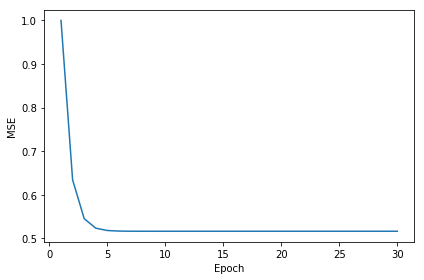

In [29]:
plt.plot(range(1, lr_gd.epochs+1), lr_gd.cost_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()

#### Linear, Numpy, Stochastic Gradient Descent


Then we implement the same using Stochastic Gradient Descent (SGD) in numpy:

In [10]:
class LinearRegressionSGD(object):

    def __init__(self, eta=0.01, epochs=50):
        self.eta = eta
        self.epochs = epochs
        
    def train(self, X, y, reinitialize_weights=True):

        n, m = X.shape
        
        if reinitialize_weights:
            self.w_ = np.zeros(1 + m)

        self.cost_ = []

        for i in range(self.epochs):
            X, y = shuffle(X, y)

            for xi, target in zip(X, y):

                output = self.net_input(xi)
                loss = (target - output)
                upd = self.eta * xi.dot(loss)
                self.w_[1:] += upd
                self.w_[0] += self.eta * loss
            
            cost = np.mean(np.square(y - self.activation(X)))
            print("Iteration %d | Cost: %f" % (i, cost))
            self.cost_.append(cost)

        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return self.net_input(X)

    def predict(self, X):
        return self.net_input(X)

In [32]:
n_iter = 30
eta=0.001

lr_sgd = LinearRegressionSGD(eta, n_iter)
lr_sgd.train(X_train, y_train);

Iteration 0 | Cost: 0.688054
Iteration 1 | Cost: 0.576598
Iteration 2 | Cost: 0.537441
Iteration 3 | Cost: 0.523460
Iteration 4 | Cost: 0.518768
Iteration 5 | Cost: 0.517055
Iteration 6 | Cost: 0.516563
Iteration 7 | Cost: 0.516589
Iteration 8 | Cost: 0.516501
Iteration 9 | Cost: 0.516583
Iteration 10 | Cost: 0.516508
Iteration 11 | Cost: 0.516489
Iteration 12 | Cost: 0.516476
Iteration 13 | Cost: 0.516475
Iteration 14 | Cost: 0.516476
Iteration 15 | Cost: 0.516480
Iteration 16 | Cost: 0.516493
Iteration 17 | Cost: 0.516493
Iteration 18 | Cost: 0.516482
Iteration 19 | Cost: 0.516475
Iteration 20 | Cost: 0.516477
Iteration 21 | Cost: 0.516486
Iteration 22 | Cost: 0.516478
Iteration 23 | Cost: 0.516493
Iteration 24 | Cost: 0.516475
Iteration 25 | Cost: 0.516505
Iteration 26 | Cost: 0.516488
Iteration 27 | Cost: 0.516498
Iteration 28 | Cost: 0.516481
Iteration 29 | Cost: 0.516475


In [33]:
print('Cost\t{:.6f}'.format(np.min(lr_sgd.cost_)))
[print('w_{:}\t{:.6f}'.format(i, w)) for i, w in enumerate(lr_sgd.w_)];

Cost	0.516475
w_0	0.000053
w_1	0.695194


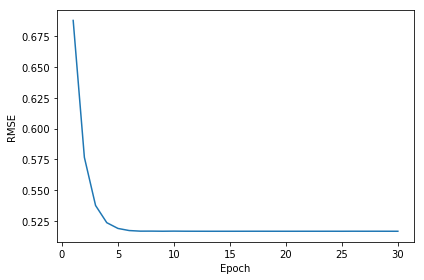

In [34]:
plt.plot(range(1, lr_sgd.epochs+1), lr_sgd.cost_)
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()

As a check, we run LR through scikit-learn:

In [39]:
from sklearn.linear_model import LinearRegression
sk_lr = LinearRegression()
sk_lr.fit(X_train, y_train)
loss = np.mean(np.square(y_train - sk_lr.predict(X_train)))
print('Cost\t {:.6f}'.format(loss))
print('w_0\t {:.10f}'.format(sk_lr.intercept_))
print('w_1\t {:.6f}'.format(sk_lr.coef_[0]))

Cost	 0.516475
w_0	 -0.0000000000
w_1	 0.695360


In [40]:
y_hat = lr_gd.predict(X_train)

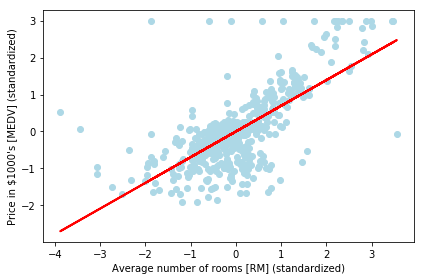

In [41]:
plt.scatter(X_train, y_train, c='lightblue')
plt.plot(X_train, y_hat, color='red', linewidth=2)   
# plt.plot(X_train, y_hat_sk, color='blue', linewidth=2)   
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import r2_score

In [43]:
r2_score(y_train, y_hat)

0.48352545599133401

### Tensorflow Version

In [44]:
class LinearRegressionTF(object):

    def __init__(self, eta=0.01, epochs=50, display_step = 10, batch_size=10):
        self.eta = eta
        self.epochs = epochs
        self.display_step_ = display_step
        self.batch_size_ = batch_size
        
    def get_minibatches(self, X):
        return zip(range(0, len(X), self.batch_size_), 
                                      range(self.batch_size_, 
                                      len(X)+1, self.batch_size_))
        
    def train(self, X, y):
        n, m = X.shape
        self.cost_ = []
    
        X_ = tf.placeholder(tf.float32)
        Y_ = tf.placeholder(tf.float32)
        
        W_ = tf.Variable(1., tf.float32, name="weight")
        
        b_ = tf.Variable(0., tf.float32, name="bias")

        output = W_ * tf.transpose(X_) + b_
        
        loss = tf.reduce_mean(tf.square(output - Y_))
        optimizer = tf.train.GradientDescentOptimizer(self.eta)
        train_step = optimizer.minimize(loss)
        
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            
            for i in range(self.epochs):
                X, y = shuffle(X, y)
                
                for start, end in self.get_minibatches(X):
                    sess.run(train_step, feed_dict={
                                                    X_: X[start:end], 
                                                    Y_: y[start:end]
                                                    })
                
                c = sess.run(loss, feed_dict={X_: X, Y_:y})                
                if (i+1) % self.display_step_ == 0:
                    print("Iteration %d | Cost: %f" % (i+1, c))

                self.cost_.append(c)
                # update weights
#                 cost_history = np.append(self.cost_,sess.run(cost,feed_dict={X: X_train,Y: y_train}))
            
            final_W, final_b, final_loss = sess.run([W_, b_, loss], 
                                                    feed_dict={X_: X, Y_: y})

            print("Training cost=", final_loss, "W=", final_W, "b=", final_b, '\n')

        return self
    
    def net_input(self, X):
        return tf.add(tf.multiply(X, self.W_), self.b_)
    
    def predict(self, X):
        return self.net_input(X)

In [45]:
X_train = X_std
y_train = y_std

In [48]:
n_iter = 30
eta=0.001
n, m = X_train.shape
print(n, m)

lr_tf = LinearRegressionTF(eta, n_iter, display_step=10, batch_size=10)
lr_tf = lr_tf.train(X_train, y_train)

506 1
Iteration 10 | Cost: 0.529150
Iteration 20 | Cost: 0.518103
Iteration 30 | Cost: 0.516676
Training cost= 0.516676 W= 0.709458 b= -0.0015076 



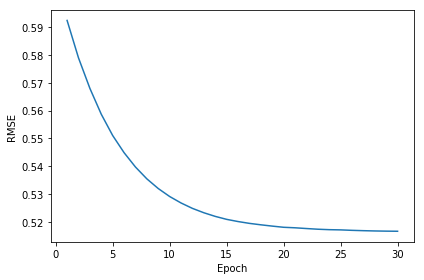

In [49]:
plt.plot(range(1, lr_tf.epochs+1), lr_tf.cost_)
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()